In [1]:
from my_image_v1 import *
import numpy as np
import cv2 as cv
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
p_piece_list = MyImage.read_pieces('./20211028-lcy-20X-1_Wholeslide_Default_Extended_image_results/good_pieces/')

reading pieces:   3%|▎         | 28/815 [00:02<01:06, 11.77it/s]


KeyboardInterrupt: 

In [2]:
piece_0_1 = MyPiece.read_piece('20211028-lcy-20X-1_Wholeslide_Default_Extended_image_results/all_pieces/piece_0_27.tiff')
piece_0_1 = MyPiece.read_piece('20211028-lcy-20X-1_Wholeslide_Default_Extended_image_results/all_pieces/piece_2_44.tiff')

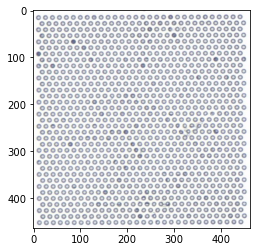

In [3]:
plt.imshow(piece_0_1.raw_plot[:,:,::-1])

In [4]:
piece_0_1.raw_plot.shape

(464, 463, 3)

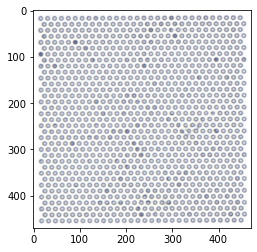

In [5]:
plt.imshow(piece_0_1.fixed_plot[:,:,::-1])

In [6]:
piece_0_1.fixed_plot.shape

(470, 470, 3)

In [5]:
piece_0_1.con_number

1048

(array([291., 564., 141.,  49.,   1.,   0.,   0.,   0.,   0.,   2.]),
 array([ 18.5 ,  29.25,  40.  ,  50.75,  61.5 ,  72.25,  83.  ,  93.75,
        104.5 , 115.25, 126.  ]),
 <BarContainer object of 10 artists>)

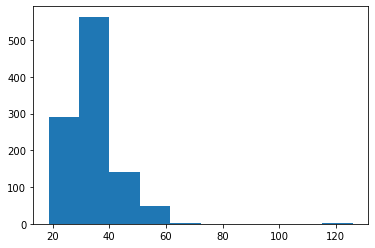

In [110]:
p = piece_0_1.raw_plot.copy()
gray = cv.cvtColor(p, cv.COLOR_BGR2GRAY)
r, p3 = cv.threshold(gray, 200, 250, cv.THRESH_BINARY_INV)
p3 = cv.medianBlur(p3, 7)
kernel2 = np.ones((3, 3), np.uint8)
erode = cv.erode(p3, kernel2, iterations=1)
#erode = cv.morphologyEx(p3, cv.MORPH_OPEN, kernel2)
binary, contours, hierarchy = cv.findContours(p3, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
contours = [con for con in contours if cv.contourArea(con) >= 15]
contours_big = [con for con in contours if cv.contourArea(con) >= 80]
p = cv.drawContours(p, contours, -1, (0, 0, 255), 1)


plt.hist([cv.contourArea(con) for con in contours])

In [111]:
len(contours_big)

2

In [27]:
len(contours)

1048

In [38]:
cv.imshow('p',p)
cv.imshow('gray',gray)
cv.imshow('p3',p3)
cv.imshow('erode',erode)
cv.waitKey(0)

-1

In [13]:
import seaborn as sns

2021-12-01 18:26:50 MainThread=> NumExpr defaulting to 8 threads.


In [8]:
spot_center_list = [spot.center_position for spot in piece_0_1.containers]

In [9]:
x_list = [x for x, _ in spot_center_list]
y_list = [y for _, y in spot_center_list]

In [21]:
len([x for x in y_list if 3<=x<=4])

941

In [41]:
tmp_containers = []
tmp_containers2 = []


for con in contours:
    x_list = [x for [[x, _]] in con]
    y_list = [y for [[_, y]] in con]
    x_res = [max(x_list), min(x_list)]
    y_res = [max(y_list), min(y_list)]
    center_x = x_res[1] + round((x_res[0] - x_res[1]) * 0.5, 3)
    center_y = y_res[1] + round((y_res[0] - y_res[1]) * 0.5, 3)
    
    x_len = x_res[0] - x_res[1]
    y_len = y_res[0] - y_res[1]
    
    tmp_containers2.append((x_len, y_len))
    tmp_containers.append((center_x, center_y))

In [43]:
tmp_containers2[0:10]

[(7, 5),
 (7, 6),
 (7, 6),
 (8, 6),
 (8, 7),
 (7, 7),
 (7, 7),
 (8, 7),
 (8, 8),
 (7, 7)]

In [45]:
x_list = [x for x, _ in tmp_containers]
y_list = [y for _, y in tmp_containers]

In [46]:
len(x_list)

1048

In [48]:
len([x for x in x_list if x == 3.5])

0

<AxesSubplot:ylabel='Density'>

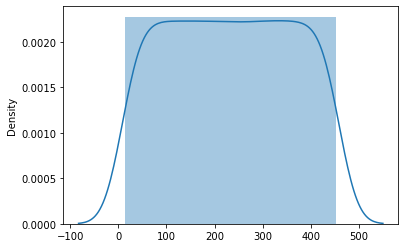

In [51]:
sns.distplot(y_list, bins=1)

D:\software\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

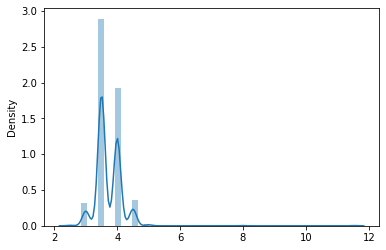

In [17]:
sns.distplot(x_list)

D:\software\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

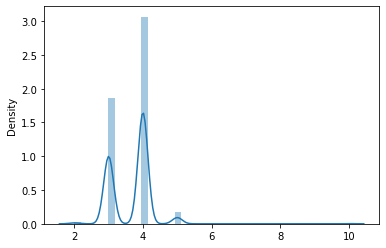

In [33]:
sns.distplot(y_list)

D:\software\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

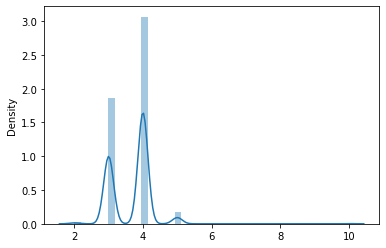

In [29]:
sns.distplot(y_list)

In [113]:
p = piece_0_1.raw_plot.copy()
p = cv.drawContours(p, new_con, -1, (0, 0, 255), 1)

In [ ]:
cv.imshow('p', p)
cv.waitKey(0)

In [107]:
len(new_con)

1050

# piece操作

In [135]:
def adjust_it(self, gap=480):
    """
    裁剪，统一所有的大小，方便piece之间的拼接：思路确定所有con中四个方向的最大值，结果保存于fixed_plot中
    填充比例为(480,480)
    """
    h, w, _ = self.raw_plot.shape
    new_con = [con for con in self.con if cv.contourArea(con) <= 10]
    x_res = []
    y_res = []
    for con in self.con:
        x_list = [x for [[x, _]] in con]
        y_list = [y for [[_, y]] in con]
        x_res += [max(x_list), min(x_list)]
        y_res += [max(y_list), min(y_list)]

    # 按照上下左右的最大值分别延申4个像素进行裁剪
    print('origin', min(y_res), max(y_res), min(x_res), max(x_res))
    
    x_min = min(x_res) - 4 if min(x_res) - 4 >= 0 else 0  # 确定左边裁剪位置
    x_max = max(x_res) + 4 if max(x_res) + 4 <= w else w  # 确定右边裁剪位置
    y_min = min(y_res) - 4 if min(y_res) - 4 >= 0 else 0  # 确定下边裁剪位置
    y_max = max(y_res) + 4 if max(y_res) + 4 <= h else h  # 确定上边裁剪位置
    x_len, y_len = x_max - x_min, y_max - y_min  # 裁切矩形的长于狂，(width, height)

    # 与 470 * 470标准矩形缝隙，在不存在交集的情况下可以直接加减(可取负数)
    up, down = math.ceil((gap - y_len) * 0.5), math.floor((gap - y_len) * 0.5)  # 上下
    left, right = math.ceil((gap - x_len) * 0.5), math.floor((gap - x_len) * 0.5)  # 左右

    x_min_scale, x_max_scale = x_min - left, x_max + right  # x左右移动
    y_min_scale, y_max_scale = y_min - down, y_max + up  # y上下移动

    if (x_len <= gap and y_len <= gap) or (x_len >= gap and y_len >= gap):
        """正常缩放，完全包括或者被包括于480*480"""
        print('1')
        if x_len < gap:
            print('a')
            scale_plot = cv.copyMakeBorder(self.raw_plot[y_min:y_max, x_min:x_max],
                                           up, down, left, right, cv.BORDER_CONSTANT,
                                           value=(255, 255, 255))
            print(y_min, y_max, x_min, x_max)
            return self.raw_plot[y_min:y_max, x_min:x_max]
        else:
            print('b')
            scale_plot = self.raw_plot[y_min_scale:y_max_scale, x_min_scale:x_max_scale]

    elif x_len > gap:
        """首先上下填充为完全包括480*480，左右裁剪成480"""
        print('2')
        up_spr, down_spr = math.ceil((gap - y_len) * 0.5), math.floor((gap - y_len) * 0.5)
        scale_plot = cv.copyMakeBorder(self.raw_plot[y_min:y_max, x_min:x_max],
                                       up_spr, down_spr, 0, 0, cv.BORDER_CONSTANT,
                                       value=(255, 255, 255))
        y_min_scale, y_max_scale = 0, gap
        scale_plot = scale_plot[y_min_scale:y_max_scale, x_min_scale:x_max_scale]

    else:
        """首先左右填充为完全包括480*480，左右裁剪成480"""
        print('3')
        left_spr, right_spr = math.ceil((gap - x_len) * 0.5), math.floor((gap - x_len) * 0.5)
        scale_plot = cv.copyMakeBorder(self.raw_plot[y_min:y_max, x_min:x_max],
                                       0, 0, left_spr, right_spr, cv.BORDER_CONSTANT,
                                       value=(255, 255, 255))
        x_min_scale, x_max_scale = 0, gap
        scale_plot = scale_plot[y_min_scale:y_max_scale, x_min_scale:x_max_scale]
    return scale_plot

In [87]:
from my_image_v1 import *
import numpy as np
import cv2 as cv
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

In [88]:
piece_0_1 = MyPiece.read_piece('20211028-lcy-20X-1_Wholeslide_Default_Extended_image_results/all_pieces/piece_0_24.tiff')

In [89]:
piece_0_1.shape

(463, 465, 3)

In [90]:
piece_0_1 = adjust_it(piece_0_1)

origin 11 456 55 457
1
a
7 460 5 461


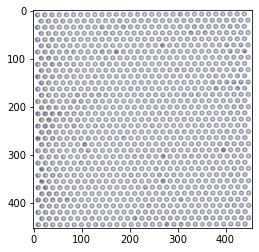

In [91]:
plt.imshow(piece_0_1[:,:,::-1])

In [17]:
p = piece_0_1.raw_plot
gray = cv.cvtColor(p, cv.COLOR_BGR2GRAY)  # 转换为灰度
r, p3 = cv.threshold(gray, 200, 250, cv.THRESH_BINARY_INV)  # 颜色二值化
p3 = cv.medianBlur(p3, 7)  # 模糊
binary, contours, hierarchy = cv.findContours(p3, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
contours = [con for con in contours if cv.contourArea(con) >= 5]
# con = cv.drawContours(p, contours, -1, (0, 0, 255), 1)

D:\software\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

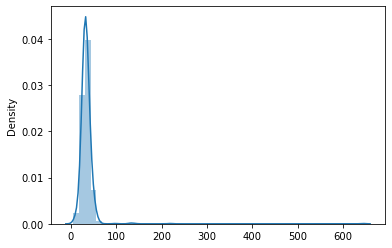

In [6]:
sns.distplot([cv.contourArea(con) for con in contours])

In [9]:
len(contours)

1069

In [12]:
con_new = MyPiece.con_fixed(contours)

NameError: name 'contours' is not defined

In [11]:
len(con_new)

1073

In [12]:
len(contours)

1069

In [19]:
p_ = piece_0_1.raw_plot
con = cv.drawContours(p, con_new, -1, (0, 0, 255), 1)

In [20]:
cv.imshow('p', p)
cv.imshow('p3', p3)
cv.imshow('con', con)
cv.waitKey(0)

-1

# 点是否水平，暂时考虑方差

In [1]:
from my_image_v1 import *
import numpy as np
import cv2 as cv
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

2021-12-03 14:07:25 MainThread=> NumExpr defaulting to 8 threads.


In [16]:
p1 = MyPiece.read_piece('./20211028-lcy-20X-1_Wholeslide_Default_Extended_image_results/good_pieces/piece_0_1.tiff')

In [17]:
len(p1.containers)

1050

In [21]:
spot_list = [v for k, v in p1.containers.items() if k[0] == 1]

In [22]:
spot_list
print(len(spot_list))
# (25.5, 30.5)
# (457.0, 29.0)

35


In [25]:
x_list = [spot.center_position[0] for spot in spot_list]

In [29]:
x_list

[33.5,
 40.5,
 33.0,
 40.5,
 33.5,
 41.0,
 33.5,
 41.0,
 33.0,
 41.0,
 33.5,
 41.0,
 34.0,
 41.5,
 34.0,
 41.5,
 34.0,
 41.5,
 33.5,
 41.5,
 33.5,
 41.0,
 34.5,
 41.5,
 34.5,
 41.5,
 34.5,
 42.5,
 34.5,
 42.5,
 34.5,
 42.0,
 34.5,
 42.5,
 35.0]

In [30]:
print(len(x_list))

35


In [34]:
np.var(x_list)

13.12530612244898

In [94]:
p1 = MyPiece.read_piece('./20211028-lcy-20X-1_Wholeslide_Default_Extended_image_results/all_pieces//piece_1_5.tiff')

In [95]:
p1.containers

{}

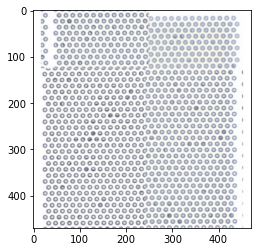

In [96]:
plt.imshow(p1.fixed_plot[:,:,::-1])

origin 9 456 9 458
1
a
5 460 5 462


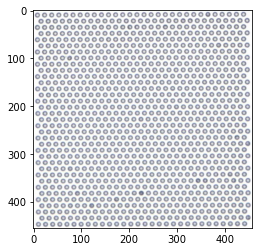

In [136]:
piece_34_38 = MyPiece.read_piece('./20211028-lcy-20X-1_Wholeslide_Default_Extended_image_results/all_pieces//piece_34_38.tiff')
piece = adjust_it(piece_34_38)
plt.imshow(piece[:,:,::-1])

In [137]:
x_res = []
y_res = []
for con in piece_34_38.con:
    x_list = [x for [[x, _]] in con]
    y_list = [y for [[_, y]] in con]
    x_res += [max(x_list), min(x_list)]
    y_res += [max(y_list), min(y_list)]

print('origin', min(y_res), max(y_res), min(x_res), max(x_res))

origin 9 456 9 458


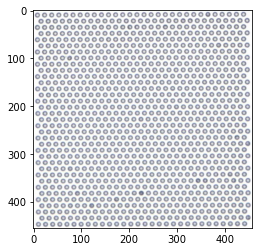

In [138]:
plt.imshow(piece_34_38.raw_plot[9-4:456+4, 9-4:458+4][:,:,::-1])

In [ ]:
x_res

In [116]:
p = piece_34_38.draw_con()

In [117]:
cv.imshow('p', p)
cv.waitKey()

-1

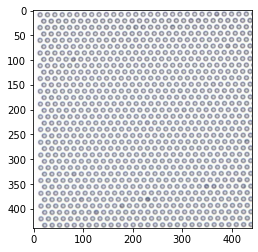

In [113]:
plt.imshow(p2_44[:,:,::-1])

In [80]:
p2_44 = adjust_it(p2_44)

origin 10 441 11 426
1
a
6 445 0 430


In [72]:
cv.imshow('p2_44',p2_44)
cv.waitKey(0)

-1

In [67]:

p2_44 = p2_44.draw_con()
cv.imshow('p2_44',p2_44)
cv.waitKey(0)

-1

In [59]:
for i in range(30):
    spot_list = [v for k, v in p1.containers.items() if k[0] == i]
    x_list = [spot.center_position[0] for spot in spot_list]
    print(np.var(y_list))

14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493
14.392653061224493


In [10]:
np.var(y_list)

0.5558333333333334

In [22]:
p = MyPiece.read_piece('./20211028-lcy-20X-1_Wholeslide_Default_Extended_image_results/good_pieces/piece_9_9.tiff')

In [23]:
p = p.draw_con()
cv.imshow('p', p)
cv.waitKey()

-1

# 正常水平：

In [71]:
good = MyPiece.read_piece('./20211028-lcy-20X-1_Wholeslide_Default_Extended_image_results/good_pieces/piece_0_1.tiff')
bad = MyPiece.read_piece('./20211028-lcy-20X-1_Wholeslide_Default_Extended_image_results/good_pieces/piece_6_9.tiff')
bad = MyPiece.read_piece('./20211028-lcy-20X-1_Wholeslide_Default_Extended_image_results/good_pieces/piece_9_9.tiff')

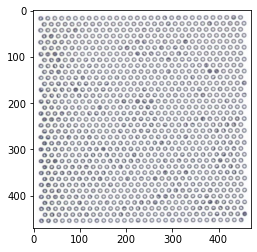

In [72]:
plt.imshow(good.fixed_plot[:,:,::-1])

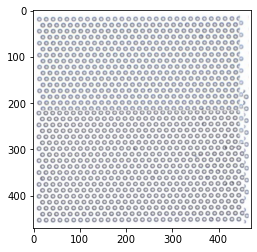

In [73]:
plt.imshow(bad.fixed_plot[:,:,::-1])

In [83]:
tmp_containers = []

for con in good.con:
    x_list = [x for [[x, _]] in con]
    y_list = [y for [[_, y]] in con]
    x_res = [max(x_list), min(x_list)]
    y_res = [max(y_list), min(y_list)]
    center_x = x_res[1] + round((x_res[0] - x_res[1]) * 0.5, 3)
    center_y = y_res[1] + round((y_res[0] - y_res[1]) * 0.5, 3)
    
    tmp_containers.append((center_x, center_y))
    
tmp_containers2 = []

for con in bad.con:
    x_list = [x for [[x, _]] in con]
    y_list = [y for [[_, y]] in con]
    x_res = [max(x_list), min(x_list)]
    y_res = [max(y_list), min(y_list)]
    center_x = x_res[1] + round((x_res[0] - x_res[1]) * 0.5, 3)
    center_y = y_res[1] + round((y_res[0] - y_res[1]) * 0.5, 3)
    
    tmp_containers2.append((center_x, center_y))

<AxesSubplot:ylabel='Count'>

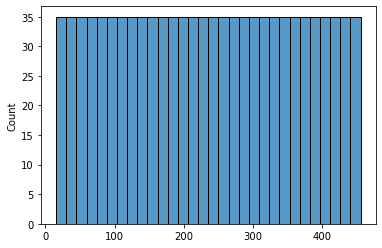

In [75]:
x_list_good = [x for (x, y) in tmp_containers]
sns.histplot(x_list_good, bins=30)

<AxesSubplot:ylabel='Count'>

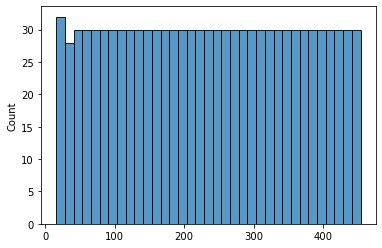

In [76]:
y_list_good = [y for (x, y) in tmp_containers]
sns.histplot(y_list_good, bins=35)

<AxesSubplot:ylabel='Count'>

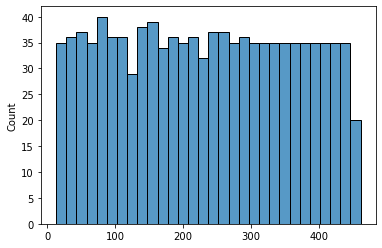

In [77]:
x_list_bad = [x for (x, y) in tmp_containers2]
sns.histplot(x_list_bad, bins=30)

<AxesSubplot:ylabel='Count'>

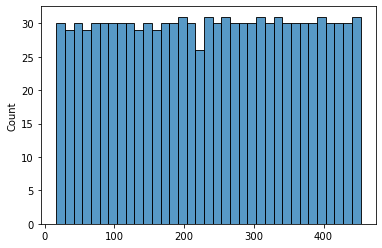

In [78]:
y_list_bad = [y for (x, y) in tmp_containers2]
sns.histplot(y_list_bad, bins=35)

In [4]:
good = good.draw_con()

In [6]:
cv.imshow('good', good)
cv.waitKey()

-1

In [81]:
good, bad

(<my_image_v1.MyPiece at 0x202655a5a30>,
 <my_image_v1.MyPiece at 0x202654d30a0>)

In [86]:
for i in range(30):
    spot_list = [v for k, v in good.containers.items() if k[0] == i]
    x_list = [spot.center_position[0] for spot in spot_list]
    print(np.var(x_list))

print('-->')

for i in range(30):
    spot_list = [v for k, v in bad.containers.items() if k[0] == i]
    print(spot_list)
#     x_list = [spot.center_position[0] for spot in spot_list]
#     print(np.var(x_list))

14.611020408163265
14.392653061224493
14.817142857142859
14.74489795918367
14.459183673469388
13.884897959183673
13.511020408163265
13.66408163265306
13.189795918367347
14.642857142857142
14.447755102040816
13.85918367346939
13.430612244897961
14.239591836734695
14.119183673469388
14.606938775510203
14.104897959183674
13.99673469387755
14.227755102040819
13.388571428571431
14.842040816326529
14.927755102040814
13.086938775510202
13.714285714285714
14.086938775510202
15.22979591836735
14.972653061224488
14.464081632653064
13.95387755102041
13.12530612244898
-->
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [70]:
for i in range(35):
    spot_list = [v for k, v in good.containers.items() if k[1] == i]
    x_list = [spot.center_position[1] for spot in spot_list]
    print(np.var(x_list))

print('-->')

for i in range(35):
    spot_list = [v for k, v in bad.containers.items() if k[1] == i]
    x_list = [spot.center_position[1] for spot in spot_list]
    print(np.var(x_list))

0.4733333333333332
0.5558333333333334
0.5655555555555556
0.5155555555555554
0.3122222222222222
0.4788888888888888
0.5613888888888889
0.5655555555555556
0.5122222222222221
0.6280555555555556
0.41805555555555557
0.49138888888888904
0.5222222222222223
0.61
0.5891666666666667
0.36000000000000004
0.4666666666666667
0.6122222222222223
0.6691666666666666
0.35583333333333333
0.3122222222222222
0.24472222222222229
0.3391666666666666
0.42916666666666664
0.5413888888888889
0.5122222222222221
0.35666666666666674
0.45
0.4166666666666667
0.4747222222222221
0.4391666666666667
0.5958333333333333
0.39333333333333337
0.36666666666666664
0.3358333333333333
-->
0.49472222222222223
0.6099999999999999
0.5725000000000001
0.5788888888888888
0.6933333333333335
0.5580555555555555
0.5391666666666667
0.5458333333333333
0.5791666666666667
0.49138888888888904
0.5747222222222224
0.5280555555555556
0.5391666666666667
0.5655555555555556
0.7447222222222223
0.4122222222222223
0.37805555555555553
0.2455555555555556
0.222

In [1]:
from my_image_v1 import *
import numpy as np
import cv2 as cv
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

2021-12-03 17:53:35 MainThread=> NumExpr defaulting to 8 threads.


In [3]:
good = MyPiece.read_piece('./20211028-lcy-20X-1_Wholeslide_Default_Extended_image_results/all_pieces/piece_0_1.tiff', relative_position=(0,1))
bad = MyPiece.read_piece('./20211028-lcy-20X-1_Wholeslide_Default_Extended_image_results/all_pieces/piece_0_23.tiff', relative_position=(0,1))
print(good.score)
print(bad.score)
print(good.score_precise)
print(bad.score_precise)

2021-12-03 17:56:11 MainThread=> 0-1 wrong distance y:7=18-20 -> 12.5


2
2
good
bad


In [15]:
p = bad.raw_plot.copy()
gray = cv.cvtColor(p, cv.COLOR_BGR2GRAY)  # 转换为灰度
r, p3 = cv.threshold(gray, 200, 250, cv.THRESH_BINARY_INV)  # 颜色二值化
p3 = cv.medianBlur(p3, 7)  # 模糊
binary, contours, hierarchy = cv.findContours(p3, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

In [20]:
new_con = [con for con in contours if cv.contourArea(con) <= 120] 

In [21]:
len(new_con)

1050

In [17]:
len(contours)

1050

In [22]:
max([cv.contourArea(con) for con in contours])

72.0

In [ ]:
con_good = good.draw_con()
con_bad = bad.draw_con()
cv.imshow('con_good',con_good)
cv.imshow('con_bad',con_bad)
cv.waitKey(0)

In [64]:
# 点的坐标 (x, y) -> (30, 35)
for i in range(35):
    spot_list = [v for k, v in bad.containers.items() if k[1] == i]
    tmp = np.mean([cv.contourArea(spot.con) for spot in spot_list])
    print('{} -> {}'.format(i, tmp))


0 -> 37.46666666666667
1 -> 40.03333333333333
2 -> 37.666666666666664
3 -> 36.38333333333333
4 -> 35.61666666666667
5 -> 32.81666666666667
6 -> 31.6
7 -> 33.333333333333336
8 -> 33.4
9 -> 32.916666666666664
10 -> 31.916666666666668
11 -> 31.666666666666668
12 -> 32.016666666666666
13 -> 32.483333333333334
14 -> 33.7
15 -> 31.2
16 -> 31.5
17 -> 31.816666666666666
18 -> 32.35
19 -> 30.616666666666667
20 -> 31.3
21 -> 33.233333333333334
22 -> 32.06666666666667
23 -> 34.0
24 -> 33.8
25 -> 30.5
26 -> 31.683333333333334
27 -> 32.43333333333333
28 -> 32.53333333333333
29 -> 33.11666666666667
30 -> 33.55
31 -> 34.96666666666667
32 -> 37.95
33 -> 38.81666666666667
34 -> 36.483333333333334


## 尝试计算相邻点的中心距离，两个方向，一个横向一个纵向

In [7]:
#横向
for i in range(30):
    
    #横向点，取出第一行按照x的相对位置进行排序
    spot_list = sorted([v for k, v in bad.containers.items() if k[0] == i], key=lambda x:x.relative_position[1])
    
    start, end = 0, 2
    pos_distance = []
    for time in range(35-1):
        spot_start, spot_end = spot_list[start:end]

        
        (start_x, start_y) = spot_start.center_position
        (end_x, end_y) = spot_end.center_position
        
        distance = round(math.sqrt(math.pow((end_x - start_x),2) + math.pow((end_y - start_y), 2)),2)
        pos_distance.append(distance)
        start += 1
        end += 1
    print(i)
    print(pos_distance)
    
    
#     for spot in spot_list:
#         print('{} -> {}'.format(spot.relative_position, spot.center_position))
#     print('*' * 10)
    

ValueError: not enough values to unpack (expected 2, got 0)

In [35]:
a = [0,1,2,3,4,5,6,7]

In [40]:
math.pow(3, 2)

9.0

In [37]:
a[0:1]

[0]

# 拼接

In [69]:
p1 = MyPiece.read_piece('./20211028-lcy-20X-1_Wholeslide_Default_Extended_image_results/good_pieces/piece_0_1.tiff')
p2 = MyPiece.read_piece('./20211028-lcy-20X-1_Wholeslide_Default_Extended_image_results/good_pieces/piece_0_2.tiff')

In [64]:
p = cv.hconcat([p1.fixed_plot,p2.fixed_plot])

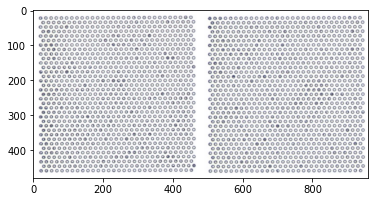

In [65]:
plt.imshow(p[:,:,::-1])